### 1. Making all the necessary imports

In [1]:
import pandas as pd
import numpy as np

from re import sub
import seaborn as sns
import matplotlib.pyplot as plt


import gc
import gensim
import itertools
from nltk.tokenize import word_tokenize
from gensim.models.word2vec import Word2Vec
from sklearn.model_selection import train_test_split

/Users/akshitasood/Desktop/py3/lib/python3.6/site-packages/matplotlib/__init__.py:1066: UserWarning: Duplicate key in file "/Users/akshitasood/.matplotlib/matplotlibrc", line #2
  (fname, cnt))


In [2]:
from keras.models import Sequential,Model
from keras import regularizers
from keras.layers.convolutional import Conv1D
from keras.layers.core import Activation,Flatten, Dropout
from keras.layers import Input, Dense, merge, Lambda,AveragePooling1D,AveragePooling2D,BatchNormalization,LeakyReLU,Activation,concatenate,GlobalMaxPooling1D
from keras.layers.pooling import MaxPooling1D
from keras.layers.merge import Concatenate
from keras import optimizers,regularizers
# from keras.callbacks import Callback
from keras import callbacks

import keras.backend as K

Using TensorFlow backend.
/Users/akshitasood/Desktop/py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/akshitasood/Desktop/py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/akshitasood/Desktop/py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/akshitasood/Desktop/py3/l

In [3]:
df = pd.read_csv("sms_data_corpus.csv")
df.head()

,Unnamed: 0,Body,Credit,Expense
0,0,Your Acc XX800006 is debited for INR 90.00 on ...,0.0,90.00
1,1,We noticed that you abandoned your cart! We've...,0.0,0.00
2,2,Acct XXX423 debited with INR105.00 on 10-Oct-1...,0.0,105.00
3,3,Your Acc XX800006 is debited for INR 577.52 on...,0.0,577.52
4,4,Acct XXX423 debited with INR18.00 on 10-Oct-19...,0.0,18.00


In [4]:
df.reset_index(inplace=True)
df.drop(columns=['index','Unnamed: 0'],inplace=True)
df.head()

,Body,Credit,Expense
0,Your Acc XX800006 is debited for INR 90.00 on ...,0.0,90.00
1,We noticed that you abandoned your cart! We've...,0.0,0.00
2,Acct XXX423 debited with INR105.00 on 10-Oct-1...,0.0,105.00
3,Your Acc XX800006 is debited for INR 577.52 on...,0.0,577.52
4,Acct XXX423 debited with INR18.00 on 10-Oct-19...,0.0,18.00


In [5]:
def getClassLabels(row):
    credit = row['Credit']
    exp = row['Expense']
    if credit==0 and exp==0:
        return 'NonTrans'
    elif credit!=0 and exp==0:
        return 'Credit'
    else:
        return 'Debit'

In [6]:
df['Label'] = df.apply(getClassLabels,axis=1)

In [7]:
df.head(10)

,Body,Credit,Expense,Label
0,Your Acc XX800006 is debited for INR 90.00 on ...,0.0,90.00,Debit
1,We noticed that you abandoned your cart! We've...,0.0,0.00,NonTrans
2,Acct XXX423 debited with INR105.00 on 10-Oct-1...,0.0,105.00,Debit
3,Your Acc XX800006 is debited for INR 577.52 on...,0.0,577.52,Debit
4,Acct XXX423 debited with INR18.00 on 10-Oct-19...,0.0,18.00,Debit
5,HSBC: Your credit card xxxxx8307 has been used...,0.0,287.00,Debit
6,HSBC: Your credit card xxxxx8307 has been used...,0.0,435.00,Debit
7,Acct XXX423 debited with INR18.00 on 09-Oct-19...,0.0,18.00,Debit
8,Dear Customer your Credit Card ending xxxxx83...,0.0,337.20,Debit
9,HSBC: Your credit card xxxxx8307 has been used...,0.0,6262.95,Debit


In [8]:
df.Label.value_counts()

Debit       2340
NonTrans     618
Credit       570
Name: Label, dtype: int64

### 2. Preprocessing the data :
#### removing all the unnecessary symbols and most common tokens from the sentences

In [9]:
def clean_text(sent):
    WEB_URL_REGEX = r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))"""
    sent = sent.lower()
    sent = sub(WEB_URL_REGEX, " ", sent) # removing url
    sent = sub(r"[^\s]+@([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?"," ",sent) #replace email with space
    sent = sent.replace('&nbsp;',' ') 
    sent = sent.replace('&amp;',' ')
    sent = sub("\d\d\d\d\d+"," ",sent) # remove numbers with more than 5 digits
    sent = sub("(\d)*xx[x]*(\d)*",' ',sent)#removing the account numbers
    sent = sub("[a-z]*[0-9]*@[a-z]*",' ',sent)#removing few @tags and email
    sent = sent.strip()
    
    return sent

In [10]:
df['sentences'] = df['Body'].apply(lambda x:clean_text(x))
df.head(20)

,Body,Credit,Expense,Label,sentences
0,Your Acc XX800006 is debited for INR 90.00 on ...,0.0,90.00,Debit,your acc is debited for inr 90.00 on 11-oct...
1,We noticed that you abandoned your cart! We've...,0.0,0.00,NonTrans,we noticed that you abandoned your cart! we've...
2,Acct XXX423 debited with INR105.00 on 10-Oct-1...,0.0,105.00,Debit,acct debited with inr105.00 on 10-oct-19 and...
3,Your Acc XX800006 is debited for INR 577.52 on...,0.0,577.52,Debit,your acc is debited for inr 577.52 on 10-oc...
4,Acct XXX423 debited with INR18.00 on 10-Oct-19...,0.0,18.00,Debit,acct debited with inr18.00 on 10-oct-19 and ...
5,HSBC: Your credit card xxxxx8307 has been used...,0.0,287.00,Debit,hsbc: your credit card has been used at godf...
6,HSBC: Your credit card xxxxx8307 has been used...,0.0,435.00,Debit,hsbc: your credit card has been used at nutr...
7,Acct XXX423 debited with INR18.00 on 09-Oct-19...,0.0,18.00,Debit,acct debited with inr18.00 on 09-oct-19 and ...
8,Dear Customer your Credit Card ending xxxxx83...,0.0,337.20,Debit,dear customer your credit card ending is de...
9,HSBC: Your credit card xxxxx8307 has been used...,0.0,6262.95,Debit,hsbc: your credit card has been used at lic ...


### 3. Exploratory Data Analysis :
#### taking a deeper look at the data, analysing the word distribution

In [11]:
df['sent_len'] = df['sentences'].apply(lambda x:len(x))
df.head()

,Body,Credit,Expense,Label,sentences,sent_len
0,Your Acc XX800006 is debited for INR 90.00 on ...,0.0,90.00,Debit,your acc is debited for inr 90.00 on 11-oct...,169
1,We noticed that you abandoned your cart! We've...,0.0,0.00,NonTrans,we noticed that you abandoned your cart! we've...,290
2,Acct XXX423 debited with INR105.00 on 10-Oct-1...,0.0,105.00,Debit,acct debited with inr105.00 on 10-oct-19 and...,102
3,Your Acc XX800006 is debited for INR 577.52 on...,0.0,577.52,Debit,your acc is debited for inr 577.52 on 10-oc...,170
4,Acct XXX423 debited with INR18.00 on 10-Oct-19...,0.0,18.00,Debit,acct debited with inr18.00 on 10-oct-19 and ...,101


Text(0,0.5,'num_sents')

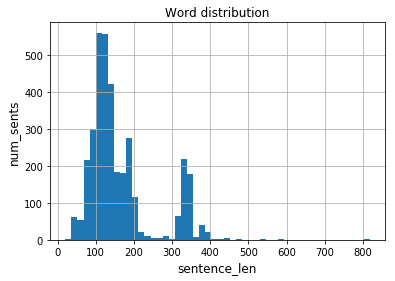

In [12]:
# word count distribution in the data
df['sent_len'].hist(bins=50,)
plt.title('Word distribution')
plt.xlabel("sentence_len", fontsize=12)
plt.ylabel("num_sents", fontsize=12)

In [13]:
# dropping the sentences with length more than 400, considering their count is very low
print(df.shape)
df = df[df['sent_len']<=400]
print(df.shape)

(3528, 6)
(3515, 6)


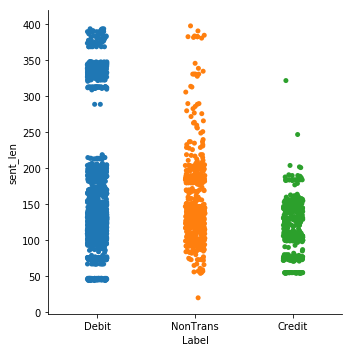

In [14]:
sns.catplot(x="Label", y="sent_len", data=df)

In [15]:
df.describe()

,Credit,Expense,sent_len
count,3.515000e+03,3512.000000,3515.000000
mean,5.235445e+03,7913.440507,161.019630
std,3.401836e+04,24967.079963,84.310562
min,0.000000e+00,0.000000,20.000000
25%,0.000000e+00,0.000000,106.000000
50%,0.000000e+00,250.000000,132.000000
75%,0.000000e+00,2492.500000,185.000000
max,1.496460e+06,600000.000000,398.000000


###  4. Modelling & Evaluation
#### training the model and then calculating the accuracy values

In [16]:
X = df['sentences']
y = df['Label']

In [17]:
# to confirm there is no index mismatch in the train and label sets
(X.index == y.index).any()

True

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1729)

In [19]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2812,), (703,), (2812,), (703,))

In [20]:
(X_train.index == y_train.index).any(),(X_test.index == y_test.index).any()

(True, True)

### 4.1 Using word2vec to get word embeddings

In [21]:
model_path = '/Users/akshitasood/Downloads/GoogleNews-vectors-negative300.bin'
print(model_path)

/Users/akshitasood/Downloads/GoogleNews-vectors-negative300.bin


In [22]:
vocab_thresh = 30000
UNKNOWN_WORD = '--unk--'
PAD_WORD = '--pad--'
PAD_NUM = 0
UNKNOWN_NUM = 1
class w2v_featuriser:
    def __init__(self,):
        self.model = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)

    def get_vocab_from_texts(self,text_2dlist):
        print("--> Getting vocab from text")
        text_list = list(itertools.chain.from_iterable(text_2dlist))
        set_vocab = set(text_list)
        list_vocab = list(set_vocab)
        list_vocab.insert(0,UNKNOWN_WORD) # vocab word at index 1 will be unknown  word
        list_vocab.insert(0,PAD_WORD) # vocab word at index 0 will be pad word
        return list_vocab

    def create_embedding_matrix(self,textarrays):
        self.subset_w2id = dict()
        print("Calculated vocab size ----> ",len(self.subset_vocab))
        loaded_w2v_weights = self.model.wv.syn0
        loaded_w2v_dim = loaded_w2v_weights.shape[1]
        self.weights = np.zeros((len(self.subset_vocab),loaded_w2v_dim), dtype='float32')
        #random_vector_padding = np.random.random_sample(size = loaded_w2v_dim)
        random_vector_unknown = np.random.random_sample(size = loaded_w2v_dim)
        #self.weights[0] = random_vector_padding
        self.weights[1] = random_vector_unknown
        self.subset_w2id[PAD_WORD] = 0
        self.subset_w2id[UNKNOWN_WORD] = 1
        i = 2
        for token in self.subset_vocab:
            if token==UNKNOWN_WORD or token==PAD_WORD:
                continue
            elif token in self.model.wv.vocab:
                self.weights[i] = self.model.wv[token]
            else: # might have to set fixed random vector for Unknown ----
                random_vector = np.random.random_sample(size = loaded_w2v_dim)
                self.weights[i] = random_vector
            self.subset_w2id[token] = i
            i+=1

    @staticmethod
    def get_max_doc_len(ser_tokens):
        maxl = ser_tokens.apply(lambda x: len(x)).max()
        return maxl
    
    def numeric_reprn_of_text(self,padded_sent_ser):
        print("Converting text into numeric form ------->")
        sent_ser = padded_sent_ser
        sent_ser = sent_ser.map(lambda x : [self.subset_w2id[y] if y in self.subset_vocab else UNKNOWN_NUM for y in x])
        return sent_ser

    def pad_numbers(self, num_list):
        pad_size = self.maxl - len(num_list)
        ret_list = list(num_list)
        if pad_size > 0:
            for i in range(pad_size):
                ret_list.append(PAD_NUM)
        else:
            ret_list = list(num_list)[:self.maxl]
        return tuple(ret_list)

    def vector_reprn_of_num_repr(self, numeric_reprn):
        print("Converting the text to vector form ---------->")
        print(numeric_reprn.head())
        vec_ser = numeric_reprn.map(lambda x: np.array([self.weights[y] for y in x]))
        return vec_ser
    
    def train(self,train_ser_doc):
        '''
        will be called only once for the train set to create vocab on train set
        '''
        tokenised_ser = train_ser_doc.apply(lambda x:word_tokenize(x))
        self.subset_vocab = self.get_vocab_from_texts(tokenised_ser.values.tolist()) 
        print(len(self.subset_vocab))
        self.subset_vocab = self.subset_vocab[:vocab_thresh+1]
        assert isinstance(tokenised_ser, pd.Series)
        subset_w2id = self.create_embedding_matrix(tokenised_ser)
        maxl = w2v_featuriser.get_max_doc_len(tokenised_ser)
        self.maxl = w2v_featuriser.get_max_doc_len(tokenised_ser)
        del self.model
        gc.collect()
        
    def apply(self,test_doc):
        '''
        will be called everytime when we need embeddings on our test sets(when the vocab has already been fixed)
        '''
        assert isinstance(test_doc, pd.Series)
        tokenised_ser = test_doc.apply(lambda x:word_tokenize(x))
        num_ser = self.numeric_reprn_of_text(tokenised_ser) # returns a 2d array
        padded_num_ser = num_ser.apply(self.pad_numbers)
        vec_ser = self.vector_reprn_of_num_repr(padded_num_ser) # returns a 3d array
        return vec_ser #will return a 3D-array of outputs

In [23]:
w2v_obj = w2v_featuriser()

In [24]:
w2v_obj.train(X_train)

--> Getting vocab from text
6534
Calculated vocab size ---->  6534


/Users/akshitasood/Desktop/py3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/Users/akshitasood/Desktop/py3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
/Users/akshitasood/Desktop/py3/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/Users/akshitasood/Desktop/py3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [25]:
X_train_feats = w2v_obj.apply(X_train)
X_train_feats

Converting text into numeric form ------->
Converting the text to vector form ---------->
1276    (4215, 1709, 1574, 3365, 279, 5255, 4694, 6041...
3129    (279, 5525, 6041, 2764, 746, 5348, 2067, 3212,...
1177    (279, 5255, 4657, 2257, 1947, 4285, 4406, 5348...
1058    (1574, 3365, 279, 1960, 6041, 2764, 2778, 5348...
3503    (279, 5255, 5870, 746, 1753, 5223, 3212, 5868,...
Name: sentences, dtype: object


1276    [[-0.24023438, 0.1171875, -0.091308594, 0.2558...
3129    [[0.19433594, 0.099609375, 0.08251953, 0.45507...
1177    [[0.19433594, 0.099609375, 0.08251953, 0.45507...
1058    [[0.076660156, 0.19921875, 0.20703125, 0.30468...
3503    [[0.19433594, 0.099609375, 0.08251953, 0.45507...
                              ...                        
3467    [[0.19433594, 0.099609375, 0.08251953, 0.45507...
1575    [[-0.24023438, 0.1171875, -0.091308594, 0.2558...
1269    [[0.19433594, 0.099609375, 0.08251953, 0.45507...
3187    [[0.482855, 0.92195684, 0.5627836, 0.83084154,...
1680    [[0.19433594, 0.099609375, 0.08251953, 0.45507...
Name: sentences, Length: 2812, dtype: object

In [26]:
X_test_feats = w2v_obj.apply(X_test)
X_test_feats

Converting text into numeric form ------->
Converting the text to vector form ---------->
2656    (4906, 2877, 2715, 1501, 1, 468, 1965, 4285, 5...
1340    (4215, 1709, 279, 420, 1947, 6041, 2764, 1814,...
913     (1574, 3365, 279, 1960, 6041, 2764, 746, 5348,...
219     (4215, 1709, 279, 420, 1947, 6041, 2764, 1814,...
1193    (4215, 1709, 1574, 3365, 279, 5255, 4694, 6041...
Name: sentences, dtype: object


2656    [[0.06347656, -0.067871094, 0.07714844, -0.219...
1340    [[-0.24023438, 0.1171875, -0.091308594, 0.2558...
913     [[0.076660156, 0.19921875, 0.20703125, 0.30468...
219     [[-0.24023438, 0.1171875, -0.091308594, 0.2558...
1193    [[-0.24023438, 0.1171875, -0.091308594, 0.2558...
                              ...                        
3033    [[0.7197196, 0.09219799, 0.7166811, 0.6622961,...
2210    [[-0.033447266, -0.21972656, 0.01940918, 0.008...
410     [[-0.08300781, 0.001953125, 0.02319336, 0.1933...
738     [[0.19433594, 0.099609375, 0.08251953, 0.45507...
3027    [[0.025634766, -0.03930664, -0.056640625, -0.0...
Name: sentences, Length: 703, dtype: object

In [27]:
y_train_dumm = pd.get_dummies(y_train)
y_test_dumm = pd.get_dummies(y_test)

In [28]:
y_test_dumm

,Credit,Debit,NonTrans
2656,0,0,1
1340,0,1,0
913,0,1,0
219,0,1,0
1193,0,1,0
...,...,...,...
3033,0,1,0
2210,0,0,1
410,0,1,0
738,1,0,0


In [29]:
y_train_dumm

,Credit,Debit,NonTrans
1276,0,1,0
3129,0,1,0
1177,0,1,0
1058,1,0,0
3503,0,1,0
...,...,...,...
3467,0,1,0
1575,0,1,0
1269,0,1,0
3187,0,1,0


In [30]:
labels = y_train_dumm.columns
labels

Index(['Credit', 'Debit', 'NonTrans'], dtype='object')

### 4.2 creating a CNN graph to learn the above embeddings

In [31]:
class build_CNN:
        
    def get_graph(self,input_shape,cnn_params):
        main_input = Input(shape=input_shape, name="input_layer")
        outputs = []
        l2_reg = regularizers.l2(cnn_params['l2_reg_value'])
        for i in cnn_params['filter_sizes']:
            filter_height = i
            conv_filter_i = Conv1D(cnn_params['no_of_filters'],filter_height,strides=1,padding='valid',kernel_initializer='he_normal', kernel_regularizer=l2_reg,data_format='channels_last')
            conved_i = conv_filter_i(main_input)
            activation_layer = Activation(cnn_params['activation'])
            activation_i = activation_layer(conved_i)

            if cnn_params['dropout']:
                activation_i = Dropout( cnn_params['dropout'])(activation_i)

            pooling_i = MaxPooling1D(pool_size= cnn_params['max_pool_filter'],strides=1,data_format='channels_last')
            pooled_i = pooling_i(activation_i)

            outputs.append(pooled_i)

        merge_conv = Concatenate(axis=1)
        merged_conv_outputs = merge_conv(outputs)

        if cnn_params['flatten']:
            merged_conv_outputs = Flatten()(merged_conv_outputs)
        graph = Model(inputs=main_input,outputs=merged_conv_outputs)
        print(graph.summary())
        return graph
   
    def build_model(self,input_shape,output_shape,cnn_params):#no_of_filters,filter_sizes):
        model = Sequential()
        core_graph = self.get_graph(input_shape,cnn_params)
        model.add(core_graph)

        l2_reg = regularizers.l2(cnn_params['l2_reg_value'])
        if cnn_params['no_of_hidden_layers'] > 0:
            for ith_no in range(cnn_params['no_of_hidden_layers']):
                hidden_layer_shape = cnn_params['hidden_layer_shapes'][ith_no]
                model.add(Dense(hidden_layer_shape,kernel_initializer= cnn_params['init'],kernel_regularizer=l2_reg))
                model.add(Activation(cnn_params['activation']))
#                 model.add(Activation('tanh'))
        model.add(Dense(output_shape,activation='softmax',kernel_initializer=cnn_params['init'],kernel_regularizer=l2_reg))
        
        adam_opt = optimizers.Adam(lr=cnn_params['learning_rate'], beta_1=cnn_params['beta1'], beta_2=cnn_params['beta2'], epsilon=1e-7, amsgrad=False)
        model.compile(loss='categorical_crossentropy', optimizer=adam_opt, metrics=['categorical_accuracy','accuracy'])
        print(model.summary())
        
        return model


In [32]:
def train_model(x_train, y_train, cnn_params, path=None, validation_split=0.2):

    if isinstance(x_train,pd.Series):
        x_train = np.array(x_train.tolist())
    print(x_train.shape)
    embedding_output_dim = x_train.shape[2]
    input_length = x_train.shape[1]
    input_shape = (input_length, embedding_output_dim)
    output_shape = y_train.shape[1]
    
    cnn_obj = build_CNN()
    model = cnn_obj.build_model(input_shape, output_shape, cnn_params)
    
    adam_opt = optimizers.Adam(lr=cnn_params['learning_rate'], beta_1=cnn_params['beta1'], beta_2=cnn_params['beta2'], epsilon=1e-7, amsgrad=False)
    model.compile(loss='categorical_crossentropy', optimizer=adam_opt, metrics=['categorical_accuracy','accuracy'])

    early_stop = callbacks.EarlyStopping(monitor='val_loss',patience=50,restore_best_weights=True,verbose=1)

    model.fit(x_train, y_train.values,batch_size = cnn_params['batch_size'],epochs = cnn_params['epochs'],
         verbose=1,callbacks=[ early_stop],validation_split = validation_split,shuffle=False)

    return model


In [33]:
cnn_params = {
            'no_of_hidden_layers': 1,
            'hidden_layer_shapes': [300],
            'epochs': 20,
            'no_of_filters': 30,
            'filter_sizes': [2, 4],
            'activation': 'relu',
            'dropout': 0.2,
            'batch_size': 32,
            'pooling_type': 'average',
            'merge_mode': 'auto',
            'learning_rate':0.001,
            'beta1':0.9,
            'beta2':0.999,
            'init':'he_normal',
            'max_pool_filter':3,
            'flatten':True,
            'validation_split':0.2,
            'l2_reg_value' :0.01

    }

In [34]:
K.clear_session()
model = train_model(X_train_feats, y_train_dumm, cnn_params, path=None, validation_split=0.2)

(2812, 87, 300)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        (None, 87, 300)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 86, 30)       18030       input_layer[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 84, 30)       36030       input_layer[0][0]                
_______________________________________________________________________________________

2249/2249 [==============================] - 5s 2ms/step - loss: 0.2355 - categorical_accuracy: 0.9795 - acc: 0.9795 - val_loss: 0.2705 - val_categorical_accuracy: 0.9698 - val_acc: 0.9698
Epoch 19/20
2249/2249 [==============================] - 5s 2ms/step - loss: 0.2356 - categorical_accuracy: 0.9778 - acc: 0.9778 - val_loss: 0.2918 - val_categorical_accuracy: 0.9591 - val_acc: 0.9591
Epoch 20/20
2249/2249 [==============================] - 5s 2ms/step - loss: 0.2445 - categorical_accuracy: 0.9773 - acc: 0.9773 - val_loss: 0.2829 - val_categorical_accuracy: 0.9609 - val_acc: 0.9609


In [35]:
def get_predictions(X_test_ser):
    x_test = np.array(X_test_ser.tolist())
    print(x_test.shape)
    preds = model.predict(x_test )
    preds = pd.DataFrame(preds, index=X_test_ser.index, columns=labels)
    return preds


In [36]:
preds = get_predictions(X_test_feats)

(703, 87, 300)


In [37]:
preds.head()

,Credit,Debit,NonTrans
2656,0.001865,0.005941,0.992193
1340,0.000131,0.999401,0.000469
913,0.001404,0.998198,0.000399
219,0.000061,0.999626,0.000313
1193,0.001387,0.998310,0.000303


In [38]:
preds_classes = preds.apply(lambda x: x.idxmax(), axis=1)
preds_classes

2656    NonTrans
1340       Debit
913        Debit
219        Debit
1193       Debit
          ...   
3033       Debit
2210    NonTrans
410        Debit
738       Credit
3027      Credit
Length: 703, dtype: object

In [39]:
df['preds'] = preds_classes
df.head()

,Body,Credit,Expense,Label,sentences,sent_len,preds
0,Your Acc XX800006 is debited for INR 90.00 on ...,0.0,90.00,Debit,your acc is debited for inr 90.00 on 11-oct...,169,NaN
1,We noticed that you abandoned your cart! We've...,0.0,0.00,NonTrans,we noticed that you abandoned your cart! we've...,290,NaN
2,Acct XXX423 debited with INR105.00 on 10-Oct-1...,0.0,105.00,Debit,acct debited with inr105.00 on 10-oct-19 and...,102,Debit
3,Your Acc XX800006 is debited for INR 577.52 on...,0.0,577.52,Debit,your acc is debited for inr 577.52 on 10-oc...,170,NaN
4,Acct XXX423 debited with INR18.00 on 10-Oct-19...,0.0,18.00,Debit,acct debited with inr18.00 on 10-oct-19 and ...,101,NaN


In [40]:
preds_final = (preds.T.max() == preds.T).T.astype(int)
preds_final.head()

,Credit,Debit,NonTrans
2656,0,0,1
1340,0,1,0
913,0,1,0
219,0,1,0
1193,0,1,0


In [41]:
y_test_dumm.shape, preds_final.shape

((703, 3), (703, 3))

In [42]:
(preds_final.index == y_test_dumm.index).any()

True

In [43]:
(preds_final.columns == y_test_dumm.columns).any()

True

In [44]:
preds_final.values

array([[0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [45]:
y_test_dumm.sort_index(inplace=True)
preds_final.sort_index(inplace=True)

In [46]:
y_test_dumm

,Credit,Debit,NonTrans
2,0,1,0
9,0,1,0
11,0,1,0
16,0,1,0
21,0,1,0
...,...,...,...
3496,0,1,0
3509,0,1,0
3510,0,1,0
3516,0,1,0


In [47]:
preds_final

,Credit,Debit,NonTrans
2,0,1,0
9,0,1,0
11,0,1,0
16,0,1,0
21,0,1,0
...,...,...,...
3496,0,1,0
3509,0,1,0
3510,0,1,0
3516,0,1,0


### 4.3 Generating the classification report

In [48]:
from sklearn.metrics import classification_report
ff = classification_report(y_test_dumm.values, preds_final.values,target_names=preds_final.columns.tolist())

print(ff)

             precision    recall  f1-score   support

     Credit       0.96      0.89      0.92       122
      Debit       0.97      0.99      0.98       465
   NonTrans       0.88      0.90      0.89       116

avg / total       0.96      0.96      0.96       703



In [49]:
y_test.value_counts()

Debit       465
Credit      122
NonTrans    116
Name: Label, dtype: int64

**Results Summary:**
_Provide a brief summary of results obtained like model accuracy & other insights based on EDA & your interpretations_

1. The model has 96% recall at 96% precision
2. The initial validation accuracy :0.8952, initial validation loss : 1.4493
3. The maximum validation accuracy is 0.9609, and minimum validation loss is 0.2829